In [1]:
import pandas as pd
import os
import sys
import re
import statsmodels.api as sm
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from import_downcasting import import_downcasting
from utils import gen_weekday_num, ts_sales_plot, adf_test_autolag

In [2]:
root = os.path.join(Path(Path(os.getcwd()).parent.absolute()), 'assets/data')


calendar = import_downcasting(os.path.join(root, "calendar.csv"))
# sales = import_downcasting(os.path.join(root, "sales_train_evaluation.csv"))
sell_price = import_downcasting(os.path.join(root, "sell_prices.csv"))

# sales_ca1 = sales[sales.store_id == "CA_1"]
# sales_ca1.to_csv(os.path.join(root, "sales_ca1.csv"), index=False)
# del sales

In [3]:
sales_ca1 = import_downcasting(os.path.join(root, "sales_ca1.csv"))
sales_ca1 = pd.melt(sales_ca1, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name="date_code", value_name ="sales")
sales_ca1 = pd.merge(left=sales_ca1, right=calendar, left_on='date_code', right_on='d', how='left')
sales_ca1 = pd.merge(left=sales_ca1, right=sell_price, left_on=['store_id', 'item_id', 'wm_yr_wk'], right_on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
sales_ca1['weekday_num'] = sales_ca1['weekday'].apply(gen_weekday_num)

In [4]:
ranked_item_unit = sales_ca1.groupby(['item_id'])['sales'].sum().sort_values(ascending=False).reset_index()
sales_ca1_rank1 = sales_ca1[sales_ca1.item_id == 'FOODS_3_090'].reset_index(drop=True)
sales_ca1_rank1 = sales_ca1_rank1.set_index('date')

<AxesSubplot:xlabel='weekday_num', ylabel='sales'>

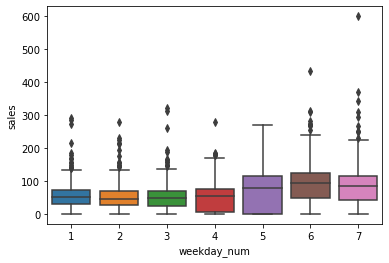

In [5]:
sns.boxplot(x="weekday_num", y='sales', data=sales_ca1_rank1, order=[1,2,3,4,5,6,7])

<Figure size 432x288 with 0 Axes>

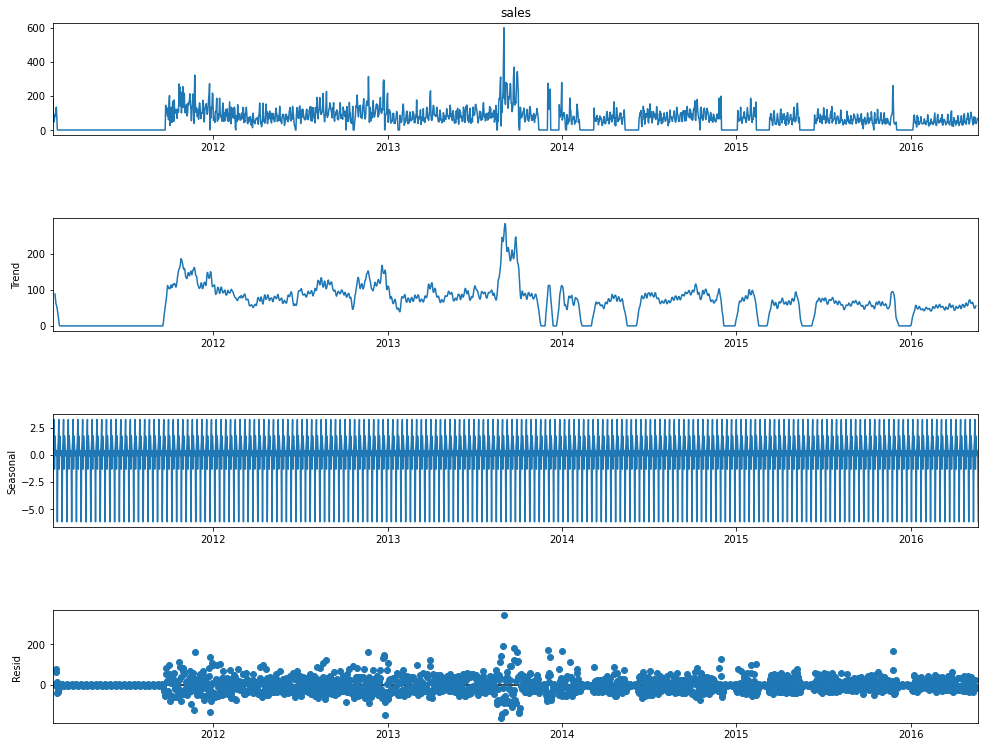

In [6]:
result = seasonal_decompose(sales_ca1_rank1['sales'], model='additive', period=10)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)


# month_year = sales_ca1_rank1.groupby(['year', 'month']).sales.sum().reset_index()
# month_year = month_year[month_year.year > 2013].reset_index()
# sns.barplot(data=month_year, x=month_year.index, y='sales')

In [7]:
sales_ca1_rank1['sales_first_diff'] = sales_ca1_rank1['sales'] - sales_ca1_rank1['sales'].shift(1)
sales_ca1_rank1 = sales_ca1_rank1.loc[sales_ca1_rank1['sales_first_diff'].notnull()]

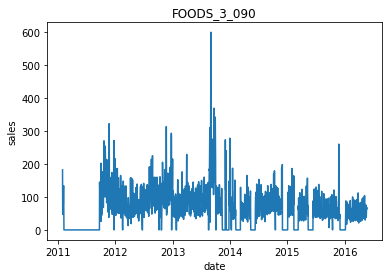

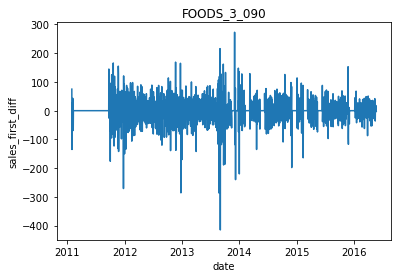

In [8]:
ts_sales_plot(sales_ca1_rank1, 'sales')
ts_sales_plot(sales_ca1_rank1, 'sales_first_diff')


In [9]:
adf_test_autolag(sales_ca1_rank1['sales'])

Results of Dickey-Fuller Test:
Test Statistic                 -4.081872
p-value                         0.001038
#Lags Used                          23.0
Number of Observations Used       1916.0
Critical Value (1%)            -3.433768
Critical Value (5%)            -2.863050
Critical Value (10%)           -2.567574
dtype: object


In [10]:
adf_test_autolag(sales_ca1_rank1['sales_first_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -12.774546
p-value                              0.0
#Lags Used                          22.0
Number of Observations Used       1917.0
Critical Value (1%)            -3.433766
Critical Value (5%)            -2.863049
Critical Value (10%)           -2.567573
dtype: object
